In [392]:
!pip install pandas
!pip install matplotlib
!pip install numpy
!pip install simpy

# Multilevel Feedback Queue scheduling (MLFQ) in CPU scheduling. 

#### Lecturer: 
Tran Van Hoai
#### Students:
Phan Minh Toan - 1852798

Tran Nhut Quang - 1852037

Trinh Minh Trung - 1852825


## 1. Introduction

In this assignment, Our group will demonstate a Multilevel Feedback Queue Scheduling in scheduling. The purpose of this assignment is to evaluate the performance of the scheduling related to CPU Utilization. 7 different mode will be carried out for comparison and evaluation. From such evaluation and comparison, conclusion for the CPU Utilization can be withdrawn from modes or each mode we generated.

## 2. Multilevel Feedback Queue scheduling (MLFQ)

Multilevel Feedback Queue is an upgrade of Multilevel queue in CPU scheduling. Multilevel Queue (MLQ) and Multilevel Feedback Queue (MLFQ) is used when processes in the ready queue can be arranged into different classes where each class have its own requirements of scheduling. The different between these two algorithms is that the MLFQ allows a process to move between queues. This function can help scheduler in separate the processes based on CPU – burst. For instance, if a process uses too much time on CPU, it will be moved to a lower-priority queue. In the other hands, if a process wait too long in lower-priority queue may be moved to a higher priority queue. This will prevent starvation.


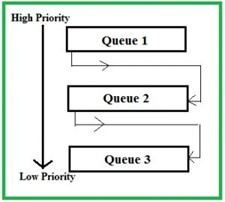

## 3.  Multilevel Feedback Queue Scheduler parameters:

A Multilevel Feedback Queue Scheduler can be defined by the following parameters:
* The number of queues.
* The scheduling algorithm for each queue.
* The method used to determine when to upgrade a process to a higher-priority queue.
* The method used to determine when to demote a process to a lower-priority queue.
* The method used to determine which queue a process will enter when that process needs service.
* The number of queues.

The definition of a multilevel feedback queue scheduler makes it the most general CPU-scheduling algorithm. However, there are some requirements for selecting values for all parameters to perform the best scheduler. 


## 4. Advantages and Disadvantages

The MLFQ brings us many benefits of scheduling:

* Flexibility.
* It allows different processes to move between different queues.
* It prevents starvation by moving a process that waits too long for the lower priority queue to the higher priority queue.

However, there exist some limitations. 

* For the selection of the best scheduler, it requires some other means to select the values.
* It produces more CPU overheads.
* It is the most complex algorithm.

## 5. Step in Performance Evaluation Project

### 5.1. Stating Goals and Defining the system

In [393]:
import simpy
import numpy.random as random
import math
import pandas as pd
import matplotlib.pyplot as plt
import os

# INITIALIZE PARAMETERS

In [394]:
LAMBDA = 10
MU = 20
QUANTUM_TIME = 10
GENERATE_MODE = 7

# FORMAT PATHFILE

In [395]:
path_file = "./output/mode{}".format(GENERATE_MODE)
log_file = open("{}/log.txt".format(path_file), "w")
queue_file = open("{}/queue.txt".format(path_file), "w")

stat_file = "{}/stat.csv".format(path_file)
FCFSQueue_file = "{}/FCFSQueue.csv".format(path_file)
RRQueue_file = "{}/RRQueue.csv".format(path_file)


# CREATE STATISTIC FILE

In [396]:
open(stat_file, 'w').close()
open(RRQueue_file, 'w').close()
open(FCFSQueue_file, 'w').close()

### CREATE TIME STATISTICS FILE

In [397]:
RR_time_stat_file = "{}/RR_time_stat_{}.csv".format(path_file, GENERATE_MODE)
FCFS_time_stat_file = "{}/FCFS_time_stat_{}.csv".format(path_file, GENERATE_MODE)
#CREATE TIME STATISTICS FILE IF NOT EXIST
if not os.path.exists(str(RR_time_stat_file)):
    open(RR_time_stat_file, 'w').close()
    
if not os.path.exists(str(FCFS_time_stat_file)):
    open(FCFS_time_stat_file, 'w').close()


# Begin Implemented Function

In [398]:
def write_to_file(path_to_file, time, who, msg):
    path_to_file.write("{}:{}{}:{}{}\n".format(time, " " * (10 - len(str(time))), who, " " * (20 - len(who)), msg))
    path_to_file.write("\n")

In [399]:
def write_queue_to_file(path_to_file, time, which, queue):
    path_to_file.write("{}:{}{}: ".format(time, " " * (10 - len(str(time))), which, " " * (20 - len(which))))
    for job in queue:
        path_to_file.write(str(job.id) + " ")
    path_to_file.write("\n")

# DELETE CSV - AVOIDING OVERWRITE

In [400]:
def deleteCSV():
    if os.path.exists(str(stat_file)):
        os.remove(str(stat_file))
        print("Delete {}".format(str(stat_file)))
    else:
        print("{} does not exist".format(str(stat_file)))

    if os.path.exists(str(FCFSQueue_file)):
        os.remove(str(FCFSQueue_file))
        print("Delete {}".format(str(FCFSQueue_file)))
    else:
        print("{} does not exist".format(str(FCFSQueue_file)))

    if os.path.exists(str(RRQueue_file)):
        os.remove(str(RRQueue_file))
        print("Delete {}".format(str(RRQueue_file)))
    else:
        print("{} does not exist".format(str(RRQueue_file)))

## Write Job Statistic to certain file

In [401]:
def write_statistic_to_file(path_to_file, job):
    process = [job.id]
    arr_time = [job.arrival_time]
    saved_burst_time = [job.saved_burst_time]
    turn_arround_time = [job.turn_around_time]
    response_time = [job.response_time]
    waiting_time = [job.waiting_time]
    
    df = pd.DataFrame(data={"process": process, 
                            "arrival": arr_time, 
                            "burst_time": saved_burst_time, 
                            "turn_arround": turn_arround_time, 
                            "response_time": response_time, 
                            "waiting_time": waiting_time})
    with open(path_to_file) as f:
        line = f.readlines()
        f.close()
    if len(line) > 0:
        df.to_csv(path_to_file, mode ='a', index = False, header= False)
    else:
        df.to_csv(path_to_file, mode ='a', index = False, header= True)

## Statistic of job
### Based on time and number of process at certain time slot

In [402]:
def write_job_in_queue(path_to_file, time, numberOfprocess):
    time = [time]
    number = [numberOfprocess]
    
    df = pd.DataFrame(data ={"time": time,
                             "Amount": number})
    with open(path_to_file) as f:
        line = f.readlines()
        f.close()
    if len(line) > 0:
        df.to_csv(path_to_file, mode ='a', index = False, header= False)
    else:
        df.to_csv(path_to_file, mode ='a', index = False, header= True)

In [403]:
class Job:
    def __init__(self, id, arrival_time, burst_time, priority):
        self.id = id
        self.arrival_time = arrival_time
        self.last_time_in_CPU = arrival_time
        self.saved_burst_time = burst_time
        self.burst_time = burst_time
        self.priority = priority
        self.turn_around_time = 0
        self.waiting_time = 0
        self.response_time = -1

In [404]:
class JobGenerator:
    def __init__(self, env):
        self.env = env
        self.inter_arrivaltime = 1 / LAMBDA
        self.service_time = 1 / MU

    def generate_job(self, mode, cpu_scheduling):
        i = 0
        while True:
            # MODE 0 - EVEN PROCESSES GO TO FCFS QUEUE, ODD PROCESSES GO TO RR
            if mode == 0:
                yield self.env.timeout(9)
                if i % 2 == 0:
                    cpu_scheduling.handle_arrival_job(Job(i, self.env.now, 10, 0))
                else:
                    cpu_scheduling.handle_arrival_job(Job(i, self.env.now, 10, 1))
                i += 1
                
           # MODE 1,2,3 - ADD PROCRESSES TO RR QUEUE, CHANGING BURST TIME FOR OBSERVATION 
            elif mode == 1:
                yield self.env.timeout(15)
                cpu_scheduling.handle_arrival_job(Job(i, self.env.now, 10, 0))
                i += 1
            elif mode == 2:
                yield self.env.timeout(15)
                cpu_scheduling.handle_arrival_job(Job(i, self.env.now, 15, 0))
                i += 1
            elif mode == 3:
                yield self.env.timeout(15)
                cpu_scheduling.handle_arrival_job(Job(i, self.env.now, 20, 0))
                i += 1
                
            # MODE 4 - ADD PROCRESSES WITH RANDOM DURATION AND RANDOM PRIORITY
            elif mode == 4:
                job_interarrival = math.trunc(random.exponential(self.inter_arrivaltime) * 100)
                yield env.timeout(job_interarrival)
                job_duration = math.trunc(random.exponential(self.service_time) * 100) + 1
                priority = random.randint(0, 2)
                cpu_scheduling.handle_arrival_job(Job(i, self.env.now, job_duration, priority))
                i += 1
                
            # MODE 5 -
            elif mode == 5:
                max_long_job = random.randint(3,5)
                n = 0
                while (n < max_long_job): 
                    job_interarrival = math.trunc(random.exponential(self.inter_arrivaltime) *100)
                    yield env.timeout(job_interarrival)
                    job_duration = math.trunc(random.exponential(self.service_time) * 100) + 1 
                    priority = 1
                    cpu_scheduling.handle_arrival_job(Job(i, self.env.now, job_duration, priority))
                    i += 1
                    n += 1
                job_interarrival = math.trunc(random.exponential(self.inter_arrivaltime) *100)
                job_duration = math.trunc(random.exponential(self.service_time)*100) + 0.5
                priority = 0
                cpu_scheduling.handle_arrival_job(Job(i, self.env.now, job_duration, priority))
                i += 1
                
            # MODE 6 - ADDING PROCESS TO FCFS QUEUE WITHOUT RR QUEUE
            elif mode == 6:
                yield self.env.timeout(15)
                cpu_scheduling.handle_arrival_job(Job(i, self.env.now, 30, 1))
                i += 1
                
            # MODE 7
            elif mode == 7:
                job_interarrival = math.trunc(random.exponential(self.inter_arrivaltime) *200)
                yield env.timeout(job_interarrival)
                job_duration = math.trunc(random.exponential(self.service_time) * 200) + 3
                priority = 1
                cpu_scheduling.handle_arrival_job(Job(i, self.env.now, job_duration, priority))
                i += 1
                max_long_job = random.randint(3,7)
                n = 0
                while (n < max_long_job): 
                    job_interarrival = math.trunc(random.exponential(self.inter_arrivaltime) *200)
                    job_duration = math.trunc(random.exponential(self.service_time)*200) + 0.25
                    priority = 0
                    cpu_scheduling.handle_arrival_job(Job(i, self.env.now, job_duration, priority))
                    i += 1
                    n += 1
                

In [405]:
class CPU:
    def __init__(self, env):
        self.env = env
        self.job_arrival_interrupt = env.event()
        self.idle_time = 0

    def serve(self, time, job):
        write_to_file(log_file, self.env.now, "CPU", "CPU is GIVEN TO process {}".format(job.id))
        try:
            yield self.env.timeout(time)
        except simpy.Interrupt as i:
            print("Interrupt: " + i.cause)
        write_to_file(log_file, self.env.now, "CPU", "Process {} LEAVE the CPU".format(job.id))
        job.last_time_in_CPU = self.env.now

    def idle(self):
        # print("{} cpu is idle".format(self.env.now))
        write_to_file(log_file, self.env.now, "CPU", "CPU is IDLE")
        t1 = self.env.now
        yield self.job_arrival_interrupt
        self.idle_time += (self.env.now - t1)

In [406]:
class CpuScheduling:
    def __init__(self, env, quantum_time=5):
        self.env = env
        self.quantum_time = quantum_time
        self.RR_queue = []
        self.FCFS_queue = []
        self.CPU = CPU(self.env)

    def handle_arrival_job(self, job):
        if job.priority == 0:
            # print("{}: Receive 1 job with priority 0".format(self.env.now))
            '''put this job to RR queue'''
            write_to_file(log_file, self.env.now, "RR queue", "Process {} burst time {} to RR queue".format(job.id, job.burst_time))
            self.RR_queue.append(job)
            write_queue_to_file(queue_file, self.env.now, "RR queue", self.RR_queue)
            write_job_in_queue(RRQueue_file, self.env.now, len(self.RR_queue))
        elif job.priority == 1:
            # print("{}: Receive 1 job with priority 1".format(self.env.now))
            '''put this job to FCFS queue'''
            write_to_file(log_file, self.env.now, "FCFS queue", "Process {} burst time {} to FCFS queue".format(job.id, job.burst_time))
            self.FCFS_queue.append(job)
            write_queue_to_file(queue_file, self.env.now, "FCFS queue", self.FCFS_queue)
            write_job_in_queue(FCFSQueue_file, self.env.now, len(self.FCFS_queue))

        self.CPU.job_arrival_interrupt.succeed()
        self.CPU.job_arrival_interrupt = self.env.event()

    def schedule(self):
        while True:
            '''check if there are any processes are waiting to be executed'''
            if (len(self.RR_queue) != 0) or (len(self.FCFS_queue) != 0):

                '''Execute all processes in RR queue'''
                while len(self.RR_queue) != 0:
                    write_queue_to_file(queue_file, self.env.now, "RR queue", self.RR_queue)
                    '''Get the process of out the queue'''
                    my_job = self.RR_queue.pop(0)
                    write_job_in_queue(RRQueue_file, self.env.now, len(self.RR_queue))

                    '''Calculate statistics of the process'''
                    if my_job.response_time == -1:
                        my_job.response_time = self.env.now - my_job.arrival_time
                    my_job.waiting_time += (self.env.now - my_job.last_time_in_CPU)

                    '''calculate duration for this process in RR algorithm'''
                    duration = min(self.quantum_time, my_job.burst_time)
                    yield self.env.process(self.CPU.serve(duration, my_job))
                    my_job.burst_time -= duration

                    '''Check if the process finishes or not'''
                    if my_job.burst_time > 0:
                        my_job.priority += 1
                        self.FCFS_queue.append(my_job)
                        write_to_file(log_file, self.env.now, "FCFS queue", "Process {} burst time {} to FCFS queue".format(my_job.id, my_job.burst_time))
                        write_queue_to_file(queue_file, self.env.now, "FCFS queue", self.FCFS_queue)
                        write_job_in_queue(FCFSQueue_file, self.env.now, len(self.FCFS_queue))
                    else:
                        '''Yes, this process finish. We calculate some other statistics'''
                        my_job.turn_around_time = self.env.now - my_job.arrival_time
                        assert my_job.turn_around_time == my_job.saved_burst_time + my_job.waiting_time
                        write_statistic_to_file(stat_file, my_job)

                ''' Execuet all process in FCFS queue'''
                while len(self.FCFS_queue) != 0:
                    write_queue_to_file(queue_file, self.env.now, "FCFS queue", self.FCFS_queue)
                    '''Get the process of out the queue'''
                    my_job = self.FCFS_queue.pop(0)
                    write_job_in_queue(FCFSQueue_file, self.env.now, len(self.FCFS_queue))

                    '''Calculate some statistics of the process'''
                    if my_job.response_time == -1:
                        my_job.response_time = self.env.now - my_job.arrival_time
                    my_job.waiting_time += (self.env.now - my_job.last_time_in_CPU)

                    '''In process with lower priority could be preempted by higher priority process'''
                    t1 = self.env.now
                    serve_proc = self.env.process(self.CPU.serve(my_job.burst_time, my_job))

                    '''wait for the process to finish or there is interrupt because
                       there is higher priority process comes'''
                    results = yield serve_proc | self.CPU.job_arrival_interrupt

                    '''Check if our process completely finishes or be interrupted by higher priority process'''
                    if serve_proc not in results:
                        serve_proc.interrupt("Higher priority process comes!")
                        interval = self.env.now - t1
                        my_job.burst_time -= interval

                        '''put the interrupted process back into FCFS queue and break'''
                        self.FCFS_queue.append(my_job)
                        write_to_file(log_file, self.env.now, "FCFS queue", "Process {} burst time {} to FCFS queue".format(my_job.id, my_job.burst_time))
                        write_queue_to_file(queue_file, self.env.now, "FCFS queue", self.FCFS_queue)
                        write_job_in_queue(FCFSQueue_file, self.env.now, len(self.FCFS_queue))
                        break
                    else:
                        '''there is no process with higher priority comes and the process completely finish.
                            We calculate some statistics for this process'''
                        my_job.turn_around_time = self.env.now - my_job.arrival_time
                        assert my_job.turn_around_time == my_job.saved_burst_time + my_job.waiting_time
                        write_statistic_to_file(stat_file, my_job)
            else:
                '''No process wait, therefore the CPU will go to IDLE state'''
                yield self.env.process(self.CPU.idle())

In [407]:
class Simulation:
    def __init__(self, env):
        self.my_job_generator = JobGenerator(env)
        self.my_cpu_scheduling = CpuScheduling(env, QUANTUM_TIME)

    def simulate(self):
        env.process(self.my_job_generator.generate_job(GENERATE_MODE, self.my_cpu_scheduling))
        env.process(self.my_cpu_scheduling.schedule())

In [408]:

print(path_file)

env = simpy.Environment()
sim = Simulation(env)
sim.simulate()
env.run(until=1000)


./output/mode7
Interrupt: Higher priority process comes!


# BEGIN PLOTTING

In [409]:
with open(FCFSQueue_file) as f:
    line = f.readlines()
    f.close()
if len(line) > 0:
    FCFS_df = pd.read_csv(FCFSQueue_file)
    haveFCFS = 1
    print(FCFS_df.describe())
else:
    haveFCFS = 0
    print("First Come First Serve Queue file empty")



             time      Amount
count  108.000000  108.000000
mean   486.048611   52.759259
std    289.628025   30.933112
min      2.000000    1.000000
25%    235.062500   25.750000
50%    501.375000   52.500000
75%    732.812500   79.250000
max    992.000000  106.000000


In [410]:
with open(RRQueue_file) as f:
    line = f.readlines()
    f.close()
if len(line) > 0:
    RR_df = pd.read_csv(RRQueue_file)
    haveRR = 1
    print(RR_df.describe())
else:
    haveRR = 0
    print("Round Robin Queue file empty")


             time      Amount
count  390.000000  390.000000
mean   515.518590   21.530769
std    289.552541   14.126233
min      2.000000    0.000000
25%    254.875000    9.000000
50%    569.375000   18.000000
75%    739.750000   37.000000
max    999.000000   49.000000


### NUMBER OF PROCESS IN QUEUE PLOTTING

Ploting with Round Robin Data and FCFS Data


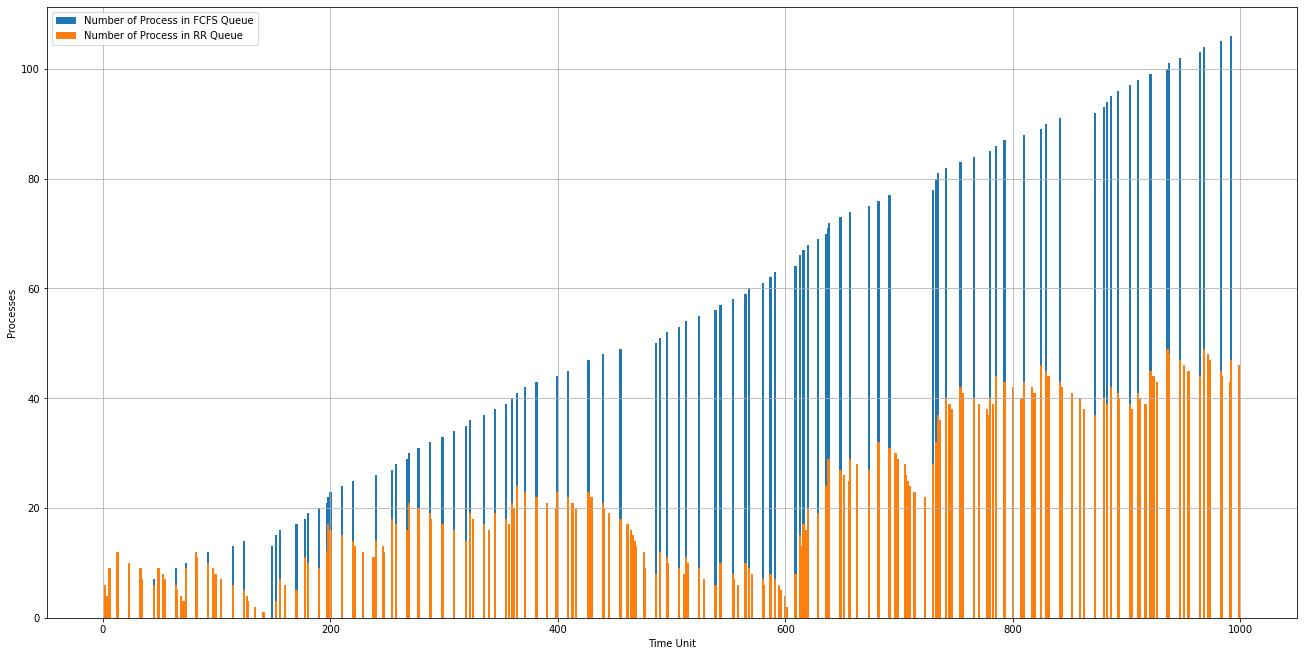

In [411]:
if haveRR and haveFCFS:
    print("Ploting with Round Robin Data and FCFS Data")
    plt.figure(figsize=(18,9), layout='constrained')
    plt.bar(FCFS_df["time"], FCFS_df["Amount"], label='Number of Process in FCFS Queue', width = 2)
    plt.bar(RR_df["time"], RR_df["Amount"], label='Number of Process in RR Queue', width = 2)
    plt.xlabel("Time Unit")
    plt.ylabel("Processes")
    plt.grid(True)
    plt.legend()
    plt.savefig("{}/stat_barplot_mode{}.png".format(path_file, GENERATE_MODE))
elif haveRR and not haveFCFS:
    print("Ploting with Round Robin Data")
    plt.figure(figsize=(18,9), layout='constrained')
    plt.bar(RR_df["time"], RR_df["Amount"], label='Number of Process in FCFS Queue', width = 2)
    plt.xlabel("Time Unit")
    plt.ylabel("Processes")
    plt.grid(True)
    plt.legend()
    plt.savefig("{}/stat_barplot_mode{}.png".format(path_file, GENERATE_MODE))
elif haveFCFS and not haveRR:
    print("Ploting with First Come First Serve Data")
    plt.figure(figsize=(18,9), layout='constrained')
    plt.bar(FCFS_df["time"], FCFS_df["Amount"], label='Number of Process in FCFS Queue', width = 2)
    plt.xlabel("Time Unit")
    plt.ylabel("Processes")
    plt.grid(True)
    plt.legend()
    plt.savefig("{}/stat_barplot_mode{}.png".format(path_file, GENERATE_MODE))
else: print("Both files empty")

### Plot Frequency of Number of process in Queue 

Ploting with Round Robin Data and FCFS Data


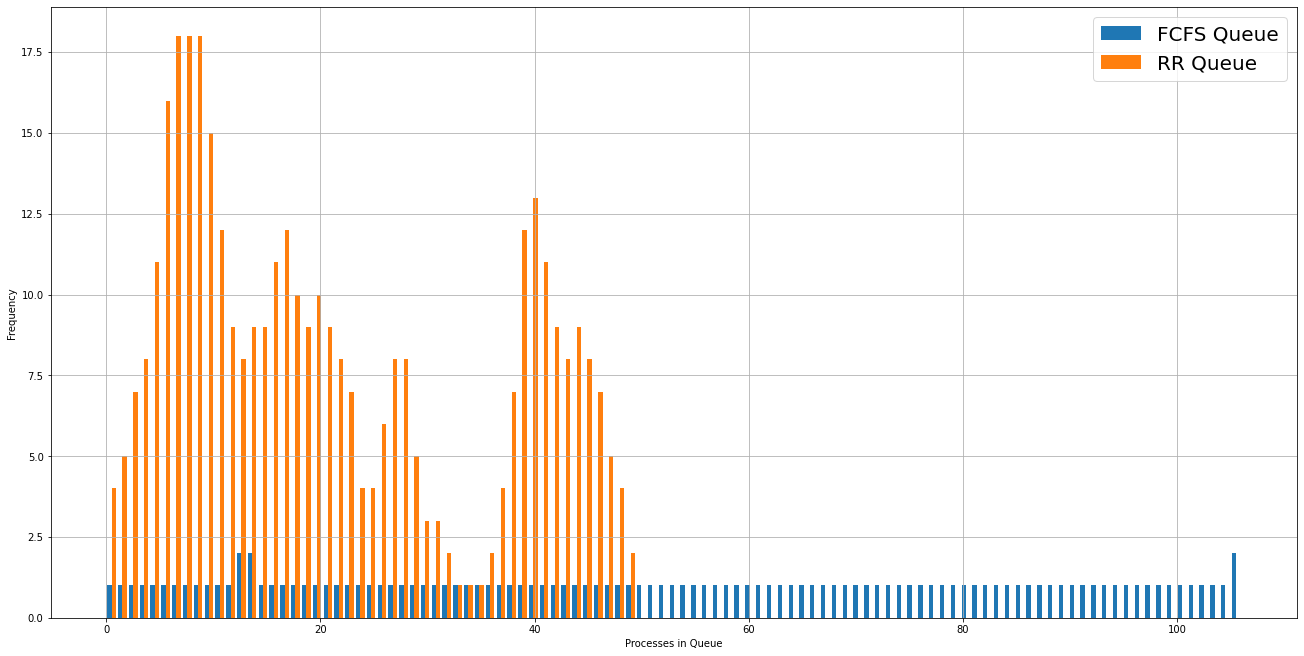

In [412]:
if haveRR and haveFCFS:
    print("Ploting with Round Robin Data and FCFS Data")
    if (FCFS_df["Amount"].nunique() > RR_df["Amount"].nunique()):
        bin_value = FCFS_df["Amount"].nunique() - 1
    else:
        bin_value = RR_df["Amount"].nunique() -1

    plt.figure(figsize=(18,9), layout='constrained')
    plt.hist([FCFS_df["Amount"], RR_df["Amount"]], bins = bin_value, label = ["FCFS Queue", "RR Queue"])
    plt.xlabel("Processes in Queue")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.legend(prop ={'size': 20})
    plt.savefig("{}/stat_histplot_mode{}.png".format(path_file, GENERATE_MODE))
elif haveRR and not haveFCFS:
    print("Ploting with Round Robin Data")
    bin_value = RR_df["Amount"].nunique() -1
    plt.figure(figsize=(18,9), layout='constrained')
    plt.hist(RR_df["Amount"], bins = bin_value, label = "RR Queue")
    plt.xlabel("Processes in Queue")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.legend(prop ={'size': 20})
    plt.savefig("{}/stat_histplot_mode{}.png".format(path_file, GENERATE_MODE))
elif haveFCFS and not haveRR:
    print("Ploting with First Come First Serve Data")
    bin_value = FCFS_df["Amount"].nunique() -1
    plt.figure(figsize=(18,9), layout='constrained')
    plt.hist(FCFS_df["Amount"], bins = bin_value, label = "FCFS Queue")
    plt.xlabel("Processes in Queue")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.legend(prop ={'size': 20})
    plt.savefig("{}/stat_histplot_mode{}.png".format(path_file, GENERATE_MODE))
else: print("Both files empty")
    



# DELETE CSV IF NECESSARY

In [413]:
# deleteCSV()